# PS reconstruction using linac phase

In [1]:
import matplotlib.pyplot as plt

import torch
from copy import deepcopy

import lightning as L

from gpsr.modeling import (
    LinacPhaseQuadDipoleLattice, 
    LinacVoltageQuadDipoleLattice,
    GPSR,
)

from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

from cheetah.particles import ParticleBeam

In [2]:
load_beam = torch.load("example_data/example_distributions/complex_beam.pt", weights_only=False)
print(load_beam.particles.shape)
print(load_beam.energy)

torch.Size([10000, 7])
tensor(43363012.)


In [3]:
incoming_beam = ParticleBeam(
    particles=load_beam.particles,
    energy=load_beam.energy,
    particle_charges= torch.ones_like(load_beam.particles[:,0])*1.0,
    survival_probabilities=torch.ones_like(load_beam.particles[:,0]),
)

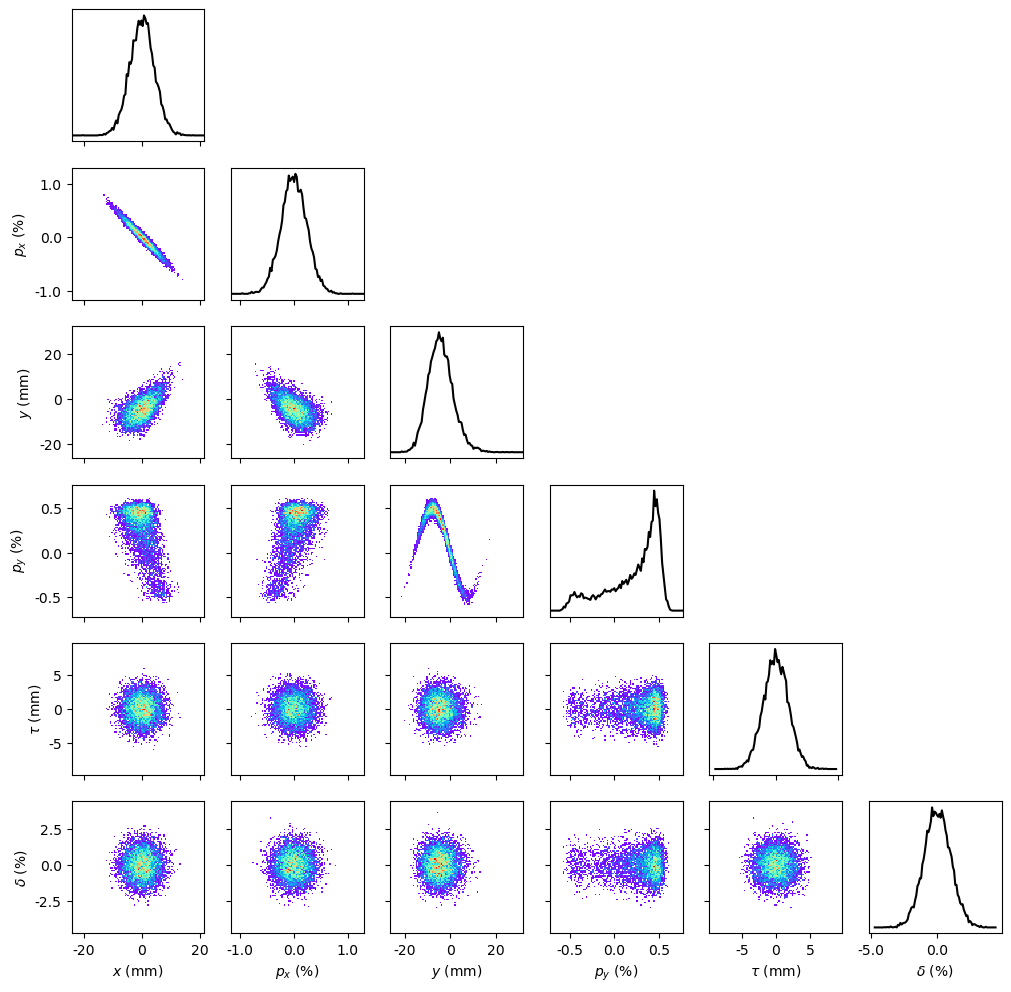

In [4]:
incoming_beam.plot_distribution()
plt.show()

In [5]:
n_pixels = 200
screen_size_mm = 100

lattice = LinacPhaseQuadDipoleLattice(
    l_linac=0.5,
    v_linac=15.0e6,
    f_linac=1.3e9,
    l_l_q=1.0,
    l_quad=0.11,
    k1_q1=0.0,
    l_q1_q2=0.2,
    k1_q2=0.0,
    l_q2_q3=0.2,
    k1_q3=0.0,
    l_q3_q4=0.2,
    l_q4_s1=1.0,
    l_s1_b=1.0,
    l_bend=0.3018,
    theta_bend=-20 * 3.14 / 180,
    l_b_s2=1.0,
    resolution_s1=(n_pixels, n_pixels),
    px_size_s1=screen_size_mm*1e-3 / n_pixels,
    resolution_s2=(n_pixels, n_pixels),
    px_size_s2=screen_size_mm*1e-3 / n_pixels
)

In [6]:
n_k1s = 5
n_phases = 5
k1s = torch.linspace(-10.0, 10.0, n_k1s) # in m^-2
#phases = 90.01+torch.linspace(-15, 15, n_phases) # in degrees
phases = 90.01+torch.linspace(-90, 90, n_phases) # in degrees

In [7]:
parameters = torch.stack(torch.meshgrid(phases, k1s), dim=-1)
parameters.shape

/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1739474897993/work/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([5, 5, 2])

In [8]:
parameters

tensor([[[ 1.0002e-02, -1.0000e+01],
         [ 1.0002e-02, -5.0000e+00],
         [ 1.0002e-02,  0.0000e+00],
         [ 1.0002e-02,  5.0000e+00],
         [ 1.0002e-02,  1.0000e+01]],

        [[ 4.5010e+01, -1.0000e+01],
         [ 4.5010e+01, -5.0000e+00],
         [ 4.5010e+01,  0.0000e+00],
         [ 4.5010e+01,  5.0000e+00],
         [ 4.5010e+01,  1.0000e+01]],

        [[ 9.0010e+01, -1.0000e+01],
         [ 9.0010e+01, -5.0000e+00],
         [ 9.0010e+01,  0.0000e+00],
         [ 9.0010e+01,  5.0000e+00],
         [ 9.0010e+01,  1.0000e+01]],

        [[ 1.3501e+02, -1.0000e+01],
         [ 1.3501e+02, -5.0000e+00],
         [ 1.3501e+02,  0.0000e+00],
         [ 1.3501e+02,  5.0000e+00],
         [ 1.3501e+02,  1.0000e+01]],

        [[ 1.8001e+02, -1.0000e+01],
         [ 1.8001e+02, -5.0000e+00],
         [ 1.8001e+02,  0.0000e+00],
         [ 1.8001e+02,  5.0000e+00],
         [ 1.8001e+02,  1.0000e+01]]])

In [9]:
lattice.set_lattice_parameters(parameters)

In [10]:
lattice.segment

Segment(elements=ModuleList(
  (0): Cavity(length=tensor(0.5000), voltage=tensor(15000000.), phase=tensor([[1.0002e-02, 1.0002e-02, 1.0002e-02, 1.0002e-02, 1.0002e-02],
          [4.5010e+01, 4.5010e+01, 4.5010e+01, 4.5010e+01, 4.5010e+01],
          [9.0010e+01, 9.0010e+01, 9.0010e+01, 9.0010e+01, 9.0010e+01],
          [1.3501e+02, 1.3501e+02, 1.3501e+02, 1.3501e+02, 1.3501e+02],
          [1.8001e+02, 1.8001e+02, 1.8001e+02, 1.8001e+02, 1.8001e+02]]), frequency=tensor(1.3000e+09), name='SCAN_LINAC')
  (1): Drift(length=tensor(0.6950), tracking_method='cheetah', name='unnamed_element_0')
  (2): Quadrupole(length=tensor(0.1100), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=5, tracking_method='bmadx', name='QUAD1')
  (3): Drift(length=tensor(0.0900), tracking_method='cheetah', name='unnamed_element_1')
  (4): Quadrupole(length=tensor(0.1100), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=5, tracking_method='bmadx', name='QUAD2')
  

In [11]:
observed_screens = lattice.track_and_observe(incoming_beam)

In [12]:
len(observed_screens)

2

In [13]:
observed_screens[0].shape

torch.Size([5, 5, 200, 200])

In [14]:
def plot_observations(observations):
    fig, ax = plt.subplots(nrows=n_phases, ncols=n_k1s, figsize=(n_k1s*4, n_phases*4))
    for i in range(n_phases):
        for j in range(n_k1s):
            ax[i,j].imshow(observed_screens[0][i,j].numpy())
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    fig.tight_layout()
    plt.show()
    fig, ax = plt.subplots(nrows=n_phases, ncols=n_k1s, figsize=(n_k1s*4, n_phases*4))
    for i in range(n_phases):
        for j in range(n_k1s):
            ax[i,j].imshow(observed_screens[1][i,j].numpy())
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    fig.tight_layout()
    plt.show()

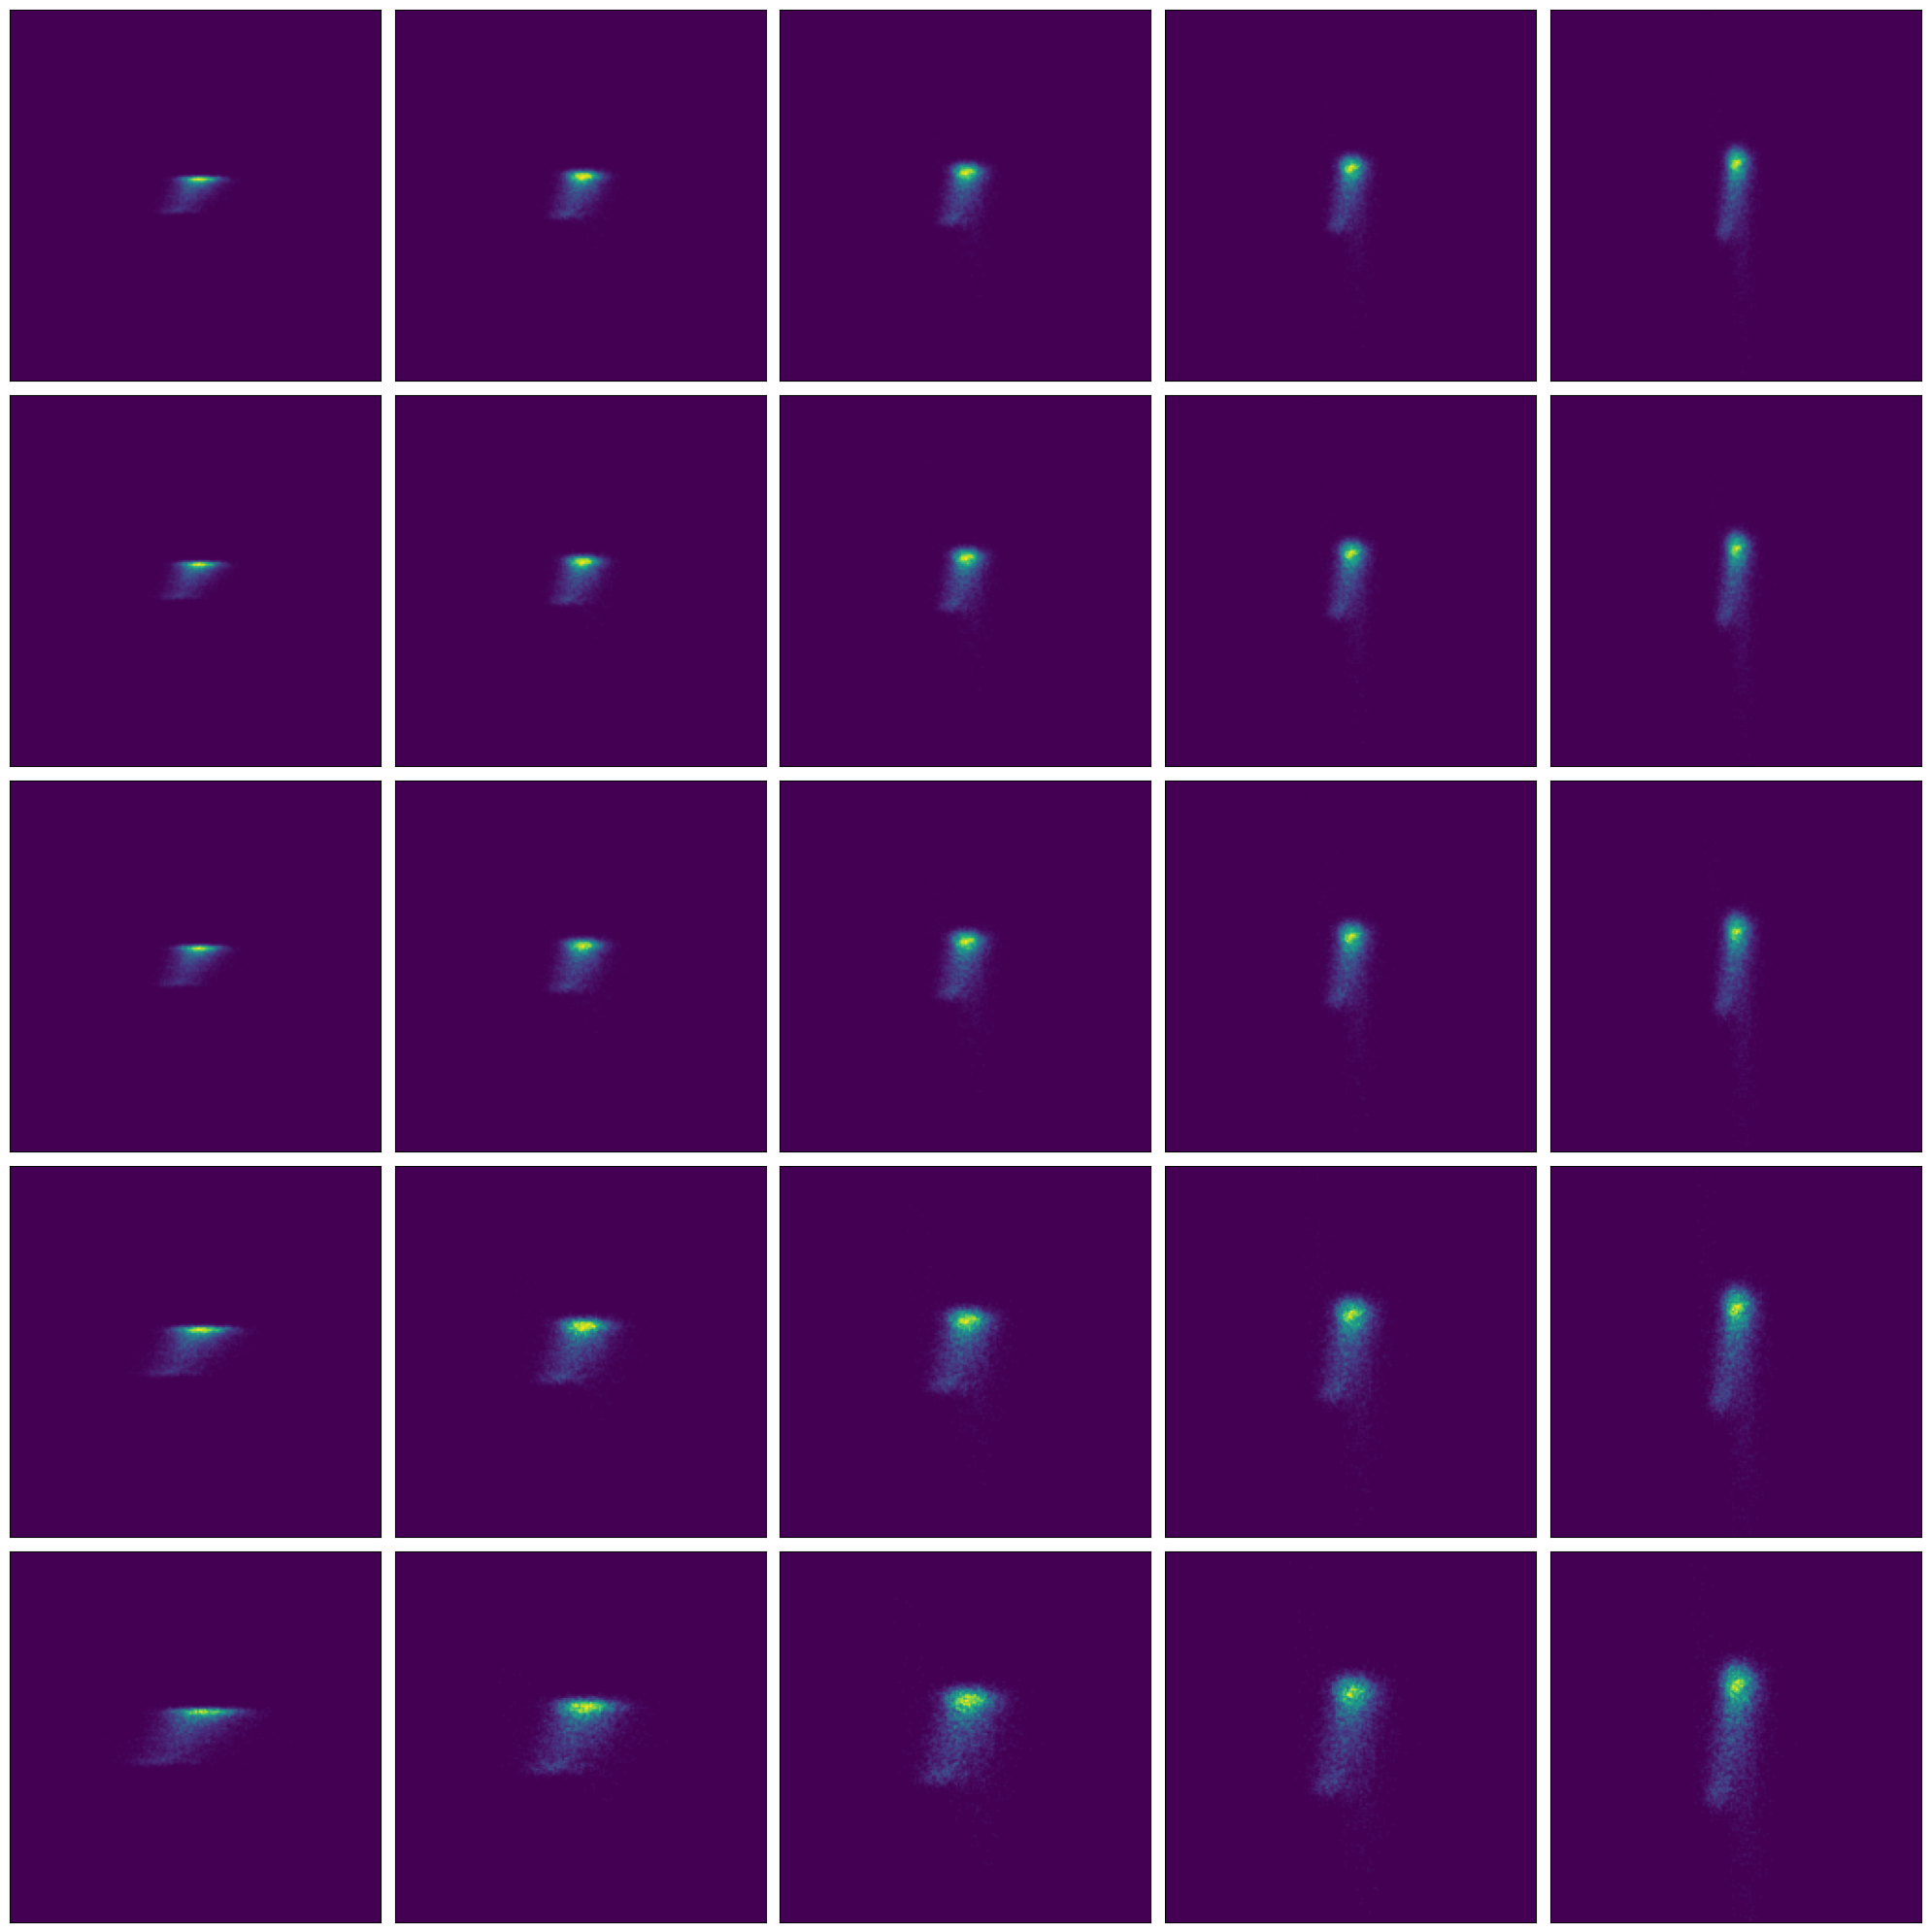

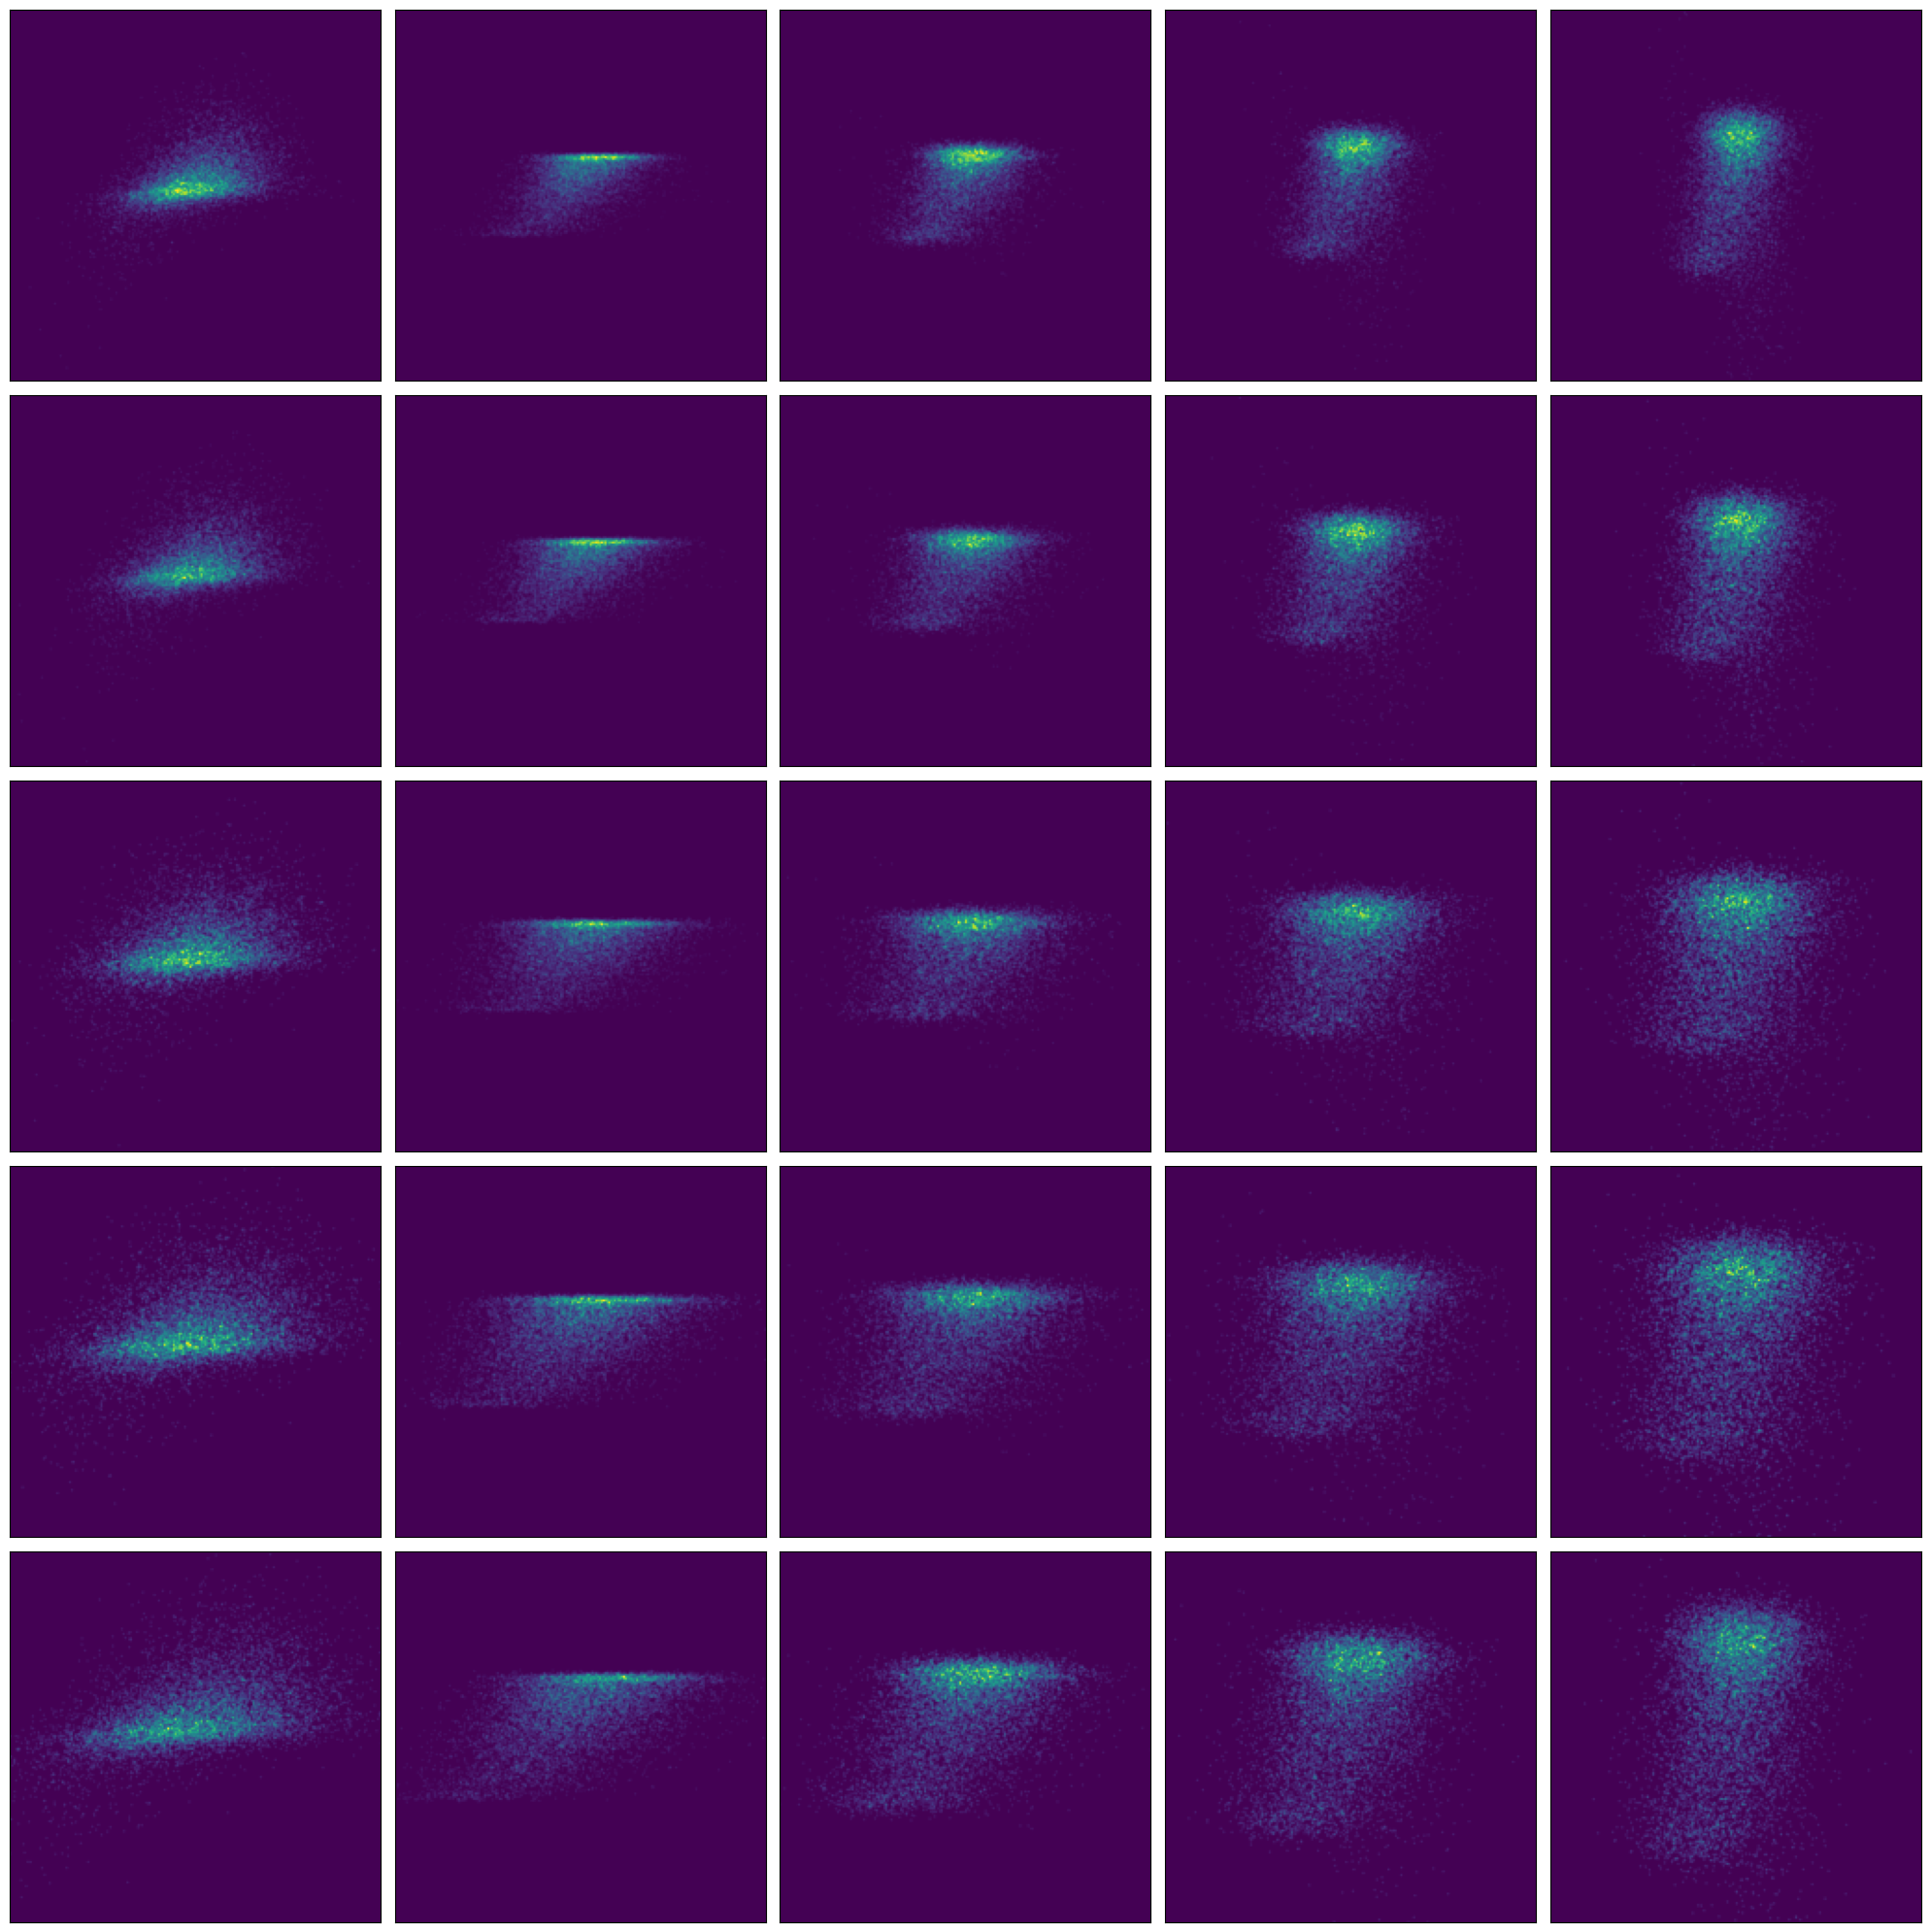

In [15]:
plot_observations(observed_screens)